In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# MIDOG2022 Mitosis Detection with Classical ML
# =============================================

import os
import json
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# Define the path to your MIDOG dataset
base_dir = '/content/drive/My Drive/MIDOG_Challenge_2022_png'
annotations_json = os.path.join(base_dir, 'MIDOG2022_training_png.json')
annotations_sqlite = os.path.join(base_dir, 'MIDOG2022_training_png.sqlite')
image_dir = base_dir



#Combined

Pipeline for working with the MIDOG2022 histopathology dataset for mitosis detection. The code performs the following key functions:

* Data Loading: Parses COCO-format JSON annotations that identify mitotic and non-mitotic figures in histopathology images.

* Visualization: Creates annotated views of the histopathology slides, showing bounding boxes around mitotic cells (green) and non-mitotic cells (red).

* Stain Normalization: Applies Reinhard normalization to standardize the appearance of histopathology slides from different sources/scanners, addressing the pan-cancer variability in the dataset.

* Patch Extraction: Crops small regions around each annotated cell, creating a dataset of image patches centered on mitotic and non-mitotic figures.

* Workflow Options: Offers both single-image processing (for testing/visualization) and batch processing (for creating a complete training dataset).

The overall goal is to prepare data for a classical machine learning pipeline for mitosis detection. By extracting normalized patches, we create consistent inputs for feature extraction, which will later feed into models like Random Forest or SVM classifiers.
The key insight is that this code bridges the gap between raw histopathology images and extracted features by:

Finding the annotations in the complex structure of the JSON file
Dealing with the variability in staining across different cancer types
Creating standardized patches that isolate the regions of interest
Providing visualization tools to verify the process is working correctly

This forms the crucial preprocessing step before feature extraction and model training in a traditional ML pipeline for microscopy image analysis.

In [ ]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev
pip install tiatoolbox
echo "Installation is done."


Reading package lists...
Building dependency tree...
Reading state information...
openslide-tools is already the newest version (3.4.1+dfsg-5build1).
libopenjp2-7-dev is already the newest version (2.4.0-6ubuntu0.3).
libpixman-1-dev is already the newest version (0.40.0-1ubuntu0.22.04.1).
libopenjp2-tools is already the newest version (2.4.0-6ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
  Using cached triton-3.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
Using cached triton-3.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (209.5 MB)
Installation is done.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.5.1 which is incompatible.


In [ ]:
base_dir = '/content/drive/My Drive/MIDOG_Challenge_2022_png'

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from tiatoolbox.tools import stainnorm

def load_and_organize_annotations(json_path):
    """
    Load COCO format annotations and organize them by image.

    Args:
        json_path: Path to the JSON annotation file

    Returns:
        image_annotations: Dictionary with image filenames as keys and their annotations as values
        categories: Dictionary mapping category IDs to names
    """
    # Load json
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # Create a mapping from image_id to filename
    image_info = {}
    for img in coco_data['images']:
        image_info[img['id']] = {
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height']
        }

    # Create a mapping from category_id to name
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

    # Organize annotations by image
    image_annotations = defaultdict(list)

    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        file_name = image_info[image_id]['file_name']

        # Create a clean annotation object
        annotation = {
            'category_id': ann['category_id'],
            'category_name': categories[ann['category_id']],
            'bbox': ann['bbox'],
            'annotation_id': ann['id']
        }

        image_annotations[file_name].append(annotation)

    return dict(image_annotations), categories, image_info

def visualize_annotations(image_path, annotations, figsize=(12, 10), max_annotations=None):
    """
    Visualize bounding box annotations on an image.

    Args:
        image_path: Path to the image file
        annotations: List of annotation objects for this image
        figsize: Size of the figure (default: (12, 10))
        max_annotations: Maximum number of annotations to display (default: None = all)

    Returns:
        None (displays the plot)
    """
    # Load the image
    try:
        img = np.array(Image.open(image_path))
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
        return

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

    # Set colors for categories
    colors = {
        'mitotic figure': 'green',
        'not mitotic figure': 'red'
    }

    # Limit number of annotations if specified
    if max_annotations is not None:
        annotations = annotations[:max_annotations]

    # Draw bounding boxes
    for ann in annotations:
        category = ann['category_name']
        x1, y1, x2, y2 = map(int, ann['bbox'])  # Convert to integers
        width = x2 - x1
        height = y2 - y1

        # Create a rectangle patch
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor=colors[category],
            facecolor='none'
        )

        # Add the rectangle to the plot
        ax.add_patch(rect)

        # Add label above the box
        plt.text(
            x1, y1 - 5,
            category,
            color=colors[category],
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=0)
        )

    # Set title with annotation counts
    mitotic_count = sum(1 for ann in annotations if ann['category_name'] == 'mitotic figure')
    non_mitotic_count = sum(1 for ann in annotations if ann['category_name'] == 'not mitotic figure')
    plt.title(f"Annotations: {mitotic_count} mitotic, {non_mitotic_count} non-mitotic")

    plt.axis('off')
    plt.tight_layout()
    plt.show()

def normalize_stain(image, target_image=None, method='macenko'):
    """
    Apply stain normalization to an image using tiatoolbox.

    Args:
        image: Input image to normalize (RGB format)
        target_image: Target image to use as a reference. If None, return original image
        method: Normalization method ('vahadane', 'macenko', 'reinhard', or 'ruifrok')

    Returns:
        Normalized image
    """
    # If no target image, return original
    if target_image is None:
        return image

    try:
        # Get appropriate normalizer
        method = method.capitalize()  # Ensure proper capitalization
        stain_normalizer = stainnorm.get_normalizer(method)

        # Fit to target image
        stain_normalizer.fit(target_image)

        # Transform the input image (make a copy to avoid modifying original)
        normalized_image = stain_normalizer.transform(image.copy())

        return normalized_image
    except Exception as e:
        print(f"Stain normalization failed with method {method}: {e}")
        # Fallback to simple normalization
        return simple_normalize_stain(image, target_image)

def simple_normalize_stain(image, target_image=None):
    """
    Apply a simple stain normalization based on LAB color space as fallback.

    Args:
        image: Input image to normalize
        target_image: Target image to use as a reference. If None, use standard values.

    Returns:
        Normalized image
    """
    from skimage import color

    # Convert to LAB color space
    lab = color.rgb2lab(image)

    # If target image is provided, use its mean and std in LAB space
    if target_image is not None:
        target_lab = color.rgb2lab(target_image)
        target_mean = np.mean(target_lab, axis=(0, 1))
        target_std = np.std(target_lab, axis=(0, 1))
    else:
        # Default target values (approximating H&E staining)
        target_mean = np.array([65.0, 10.0, 5.0])  # L, a, b channels
        target_std = np.array([20.0, 15.0, 15.0])

    # Calculate current image statistics
    img_mean = np.mean(lab, axis=(0, 1))
    img_std = np.std(lab, axis=(0, 1))

    # Normalize each channel
    normalized_lab = np.zeros_like(lab)
    for i in range(3):  # L, a, b channels
        normalized_lab[:, :, i] = ((lab[:, :, i] - img_mean[i]) /
                                  (img_std[i] + 1e-8) * target_std[i] +
                                  target_mean[i])

    # Convert back to RGB
    normalized_img = color.lab2rgb(normalized_lab)

    # Ensure values are in valid range [0, 1]
    normalized_img = np.clip(normalized_img, 0, 1)

    # Convert to uint8 format
    normalized_img = (normalized_img * 255).astype(np.uint8)

    return normalized_img

def extract_patches_with_normalization(image_path, annotations, target_image=None, patch_size=128, padding=5, method='macenko'):
    """
    Extract patches from an image with stain normalization applied.

    Args:
        image_path: Path to the image file
        annotations: List of annotation objects for this image
        target_image: Target image for stain normalization (optional)
        patch_size: Size of square patches to extract (default: 128px)
        padding: Extra padding around the bounding box (default: 5px)
        method: Normalization method ('vahadane', 'macenko', 'reinhard', or 'ruifrok')

    Returns:
        patches: Dictionary of extracted patches with category names as keys
    """
    # Load the image
    try:
        img = np.array(Image.open(image_path))
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
        return {}

    # Apply stain normalization
    normalized_img = normalize_stain(img, target_image, method)

    # Initialize dictionary to store patches
    extracted_patches = {
        'mitotic figure': [],
        'not mitotic figure': []
    }

    height, width = normalized_img.shape[0], normalized_img.shape[1]

    # Extract patches for each annotation
    for ann in annotations:
        category = ann['category_name']

        # Get bbox coordinates
        x1, y1, x2, y2 = map(int, ann['bbox'])

        # Calculate center of bounding box
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Calculate patch boundaries with padding
        half_size = patch_size // 2
        patch_x1 = max(0, center_x - half_size - padding)
        patch_y1 = max(0, center_y - half_size - padding)
        patch_x2 = min(width, center_x + half_size + padding)
        patch_y2 = min(height, center_y + half_size + padding)

        # Extract the patch from the normalized image
        patch = normalized_img[patch_y1:patch_y2, patch_x1:patch_x2]

        # Only save if the patch is valid (not empty)
        if patch.size > 0:
            # Resize to fixed size if needed
            patch_pil = Image.fromarray(patch)
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                patch_pil = patch_pil.resize((patch_size, patch_size))

            extracted_patches[category].append({
                'patch': np.array(patch_pil),
                'original_bbox': [x1, y1, x2, y2],
                'patch_coords': [patch_x1, patch_y1, patch_x2, patch_y2],
                'annotation_id': ann['annotation_id']
            })

    return extracted_patches

def visualize_extracted_patches(patches, category, num_samples=5, figsize=(15, 3)):
    """
    Visualize a sample of extracted patches.

    Args:
        patches: Dictionary of extracted patches
        category: Category to visualize ('mitotic figure' or 'not mitotic figure')
        num_samples: Number of sample patches to display
        figsize: Size of the figure

    Returns:
        None (displays the plot)
    """
    if category not in patches or not patches[category]:
        print(f"No patches found for category: {category}")
        return

    # Select samples (use all if fewer than requested)
    samples = patches[category][:num_samples]
    n_samples = len(samples)

    # Create plot
    fig, axes = plt.subplots(1, n_samples, figsize=figsize)
    if n_samples == 1:
        axes = [axes]  # Make sure axes is iterable even with one sample

    # Plot each sample
    for i, sample in enumerate(samples):
        axes[i].imshow(sample['patch'])
        axes[i].set_title(f"ID: {sample['annotation_id']}")
        axes[i].axis('off')

    plt.suptitle(f"Sample {category} patches")
    plt.tight_layout()
    plt.show()

def visualize_normalization_effect(image_path, target_image_path=None, method='macenko'):
    """
    Visualize the effect of stain normalization on an image.

    Args:
        image_path: Path to the image to normalize
        target_image_path: Path to the target image for normalization (optional)
        method: Normalization method ('vahadane', 'macenko', 'reinhard', or 'ruifrok')
    """
    # Load images
    img = np.array(Image.open(image_path))

    target_img = None
    if target_image_path and os.path.exists(target_image_path):
        target_img = np.array(Image.open(target_image_path))
    else:
        print("No target image provided, showing original image only")
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        return

    # Apply normalization
    normalized_img = normalize_stain(img, target_img, method)

    # Display original and normalized images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(target_img)
    axes[1].set_title("Target Image")
    axes[1].axis('off')

    axes[2].imshow(normalized_img)
    axes[2].set_title(f"Normalized Image ({method})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def process_all_images(base_dir, annotations_json, target_image_path=None, patch_size=128, padding=5, limit=None, method='macenko'):
    """
    Process all images in the dataset to extract normalized patches.

    Args:
        base_dir: Base directory containing images
        annotations_json: Path to the JSON annotation file
        target_image_path: Path to target image for normalization (optional)
        patch_size: Size of patches to extract
        padding: Padding around annotations
        limit: Optional limit on number of images to process (for testing)
        method: Normalization method ('vahadane', 'macenko', 'reinhard', or 'ruifrok')

    Returns:
        all_patches: Dictionary of all extracted patches from all images
    """
    # Load target image for normalization if provided
    target_image = None
    if target_image_path and os.path.exists(target_image_path):
        target_image = np.array(Image.open(target_image_path))

    # Load annotations
    print("Loading annotations...")
    image_annotations, categories, image_info = load_and_organize_annotations(annotations_json)
    print(f"Loaded annotations for {len(image_annotations)} images")

    # Limit number of images if specified (for testing)
    if limit and limit < len(image_annotations):
        # Select a subset of images with both categories if possible
        image_filenames = list(image_annotations.keys())
        print(f"Limiting to {limit} images out of {len(image_annotations)} total")
        image_annotations = {k: image_annotations[k] for k in image_filenames[:limit]}

    # Initialize dictionary for all patches
    all_patches = {
        'mitotic figure': [],
        'not mitotic figure': []
    }

    # Process each image
    print("Extracting patches with stain normalization...")
    for image_filename, annotations in tqdm(image_annotations.items()):
        # Find image path
        image_path = os.path.join(base_dir, image_filename)
        if not os.path.exists(image_path):
            # Try to find the image in subdirectories
            found = False
            for root, dirs, files in os.walk(base_dir):
                if image_filename in files:
                    image_path = os.path.join(root, image_filename)
                    found = True
                    break
            if not found:
                print(f"Image not found: {image_filename}")
                continue

        # Extract patches with normalization
        patches = extract_patches_with_normalization(
            image_path,
            annotations,
            target_image,
            patch_size,
            padding,
            method
        )

        # Add to collection
        for category in patches:
            all_patches[category].extend(patches[category])

    print(f"Extracted {len(all_patches['mitotic figure'])} mitotic figure patches")
    print(f"Extracted {len(all_patches['not mitotic figure'])} non-mitotic figure patches")

    return all_patches

def demo_workflow(base_dir, image_filename=None, patch_size=128, use_normalization=True, method='macenko'):
    """
    Demonstrate the complete workflow with a single image.

    Args:
        base_dir: Base directory containing images and annotations
        image_filename: Optional specific image to process (if None, will pick one)
        patch_size: Size of patches to extract
        use_normalization: Whether to use stain normalization
        method: Normalization method ('vahadane', 'macenko', 'reinhard', or 'ruifrok')

    Returns:
        patches: Extracted patches from the demo image
    """
    # Paths
    annotations_json = os.path.join(base_dir, 'MIDOG2022_training_png.json')

    # Load annotations
    print("Loading and organizing annotations...")
    image_annotations, categories, image_info = load_and_organize_annotations(annotations_json)
    print(f"Loaded annotations for {len(image_annotations)} images")

    # If no specific image is provided, find one with both mitotic and non-mitotic figures
    if image_filename is None:
        # Find images with both mitotic and non-mitotic figures
        candidate_images = []
        for img_file, anns in image_annotations.items():
            mitotic = any(a['category_name'] == 'mitotic figure' for a in anns)
            non_mitotic = any(a['category_name'] == 'not mitotic figure' for a in anns)
            if mitotic and non_mitotic:
                mitotic_count = sum(1 for a in anns if a['category_name'] == 'mitotic figure')
                candidate_images.append((img_file, mitotic_count))

        # Sort by number of mitotic figures and pick one with a moderate number
        if candidate_images:
            candidate_images.sort(key=lambda x: x[1])
            # Pick one from the middle of the list for a balanced example
            image_filename = candidate_images[len(candidate_images)//2][0]
            print(f"Selected image: {image_filename} with {candidate_images[len(candidate_images)//2][1]} mitotic figures")
        else:
            # Just pick the first image
            image_filename = list(image_annotations.keys())[0]
            print(f"No images with both categories found. Using first image: {image_filename}")

    # Find the image path
    image_path = os.path.join(base_dir, image_filename)
    if not os.path.exists(image_path):
        # Try to find the image in subdirectories
        found = False
        for root, dirs, files in os.walk(base_dir):
            if image_filename in files:
                image_path = os.path.join(root, image_filename)
                print(f"Found image at: {image_path}")
                found = True
                break
        if not found:
            print(f"Image not found: {image_filename}")
            return None

    # Get annotations for this image
    annotations = image_annotations[image_filename]
    print(f"Image has {len(annotations)} annotations")

    # Visualize annotations
    print("\nVisualizing annotations...")
    visualize_annotations(image_path, annotations, max_annotations=50)  # Limit to 50 for clarity

    # For stain normalization demonstration, find another image to use as target
    if use_normalization:
        # Get a different image for target
        other_images = [img for img in list(image_annotations.keys()) if img != image_filename]
        if other_images:
            target_img_filename = other_images[0]
            target_img_path = os.path.join(base_dir, target_img_filename)

            # If target image not in base dir, try to find it
            if not os.path.exists(target_img_path):
                for root, dirs, files in os.walk(base_dir):
                    if target_img_filename in files:
                        target_img_path = os.path.join(root, target_img_filename)
                        break

            if os.path.exists(target_img_path):
                print("\nDemonstrating stain normalization effect...")
                visualize_normalization_effect(image_path, target_img_path, method)
                target_img = np.array(Image.open(target_img_path))
            else:
                print("Could not find a suitable target image for normalization")
                target_img = None
        else:
            target_img = None
    else:
        target_img = None

    # Extract patches (with or without normalization)
    print("\nExtracting patches...")
    if use_normalization and target_img is not None:
        patches = extract_patches_with_normalization(
            image_path,
            annotations,
            target_img,
            patch_size=patch_size,
            method=method
        )
    else:
        # Simplified version without normalization
        img = np.array(Image.open(image_path))
        patches = {
            'mitotic figure': [],
            'not mitotic figure': []
        }

        for ann in annotations:
            category = ann['category_name']
            x1, y1, x2, y2 = map(int, ann['bbox'])

            # Calculate center of bounding box
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2

            # Calculate patch boundaries
            half_size = patch_size // 2
            patch_x1 = max(0, center_x - half_size)
            patch_y1 = max(0, center_y - half_size)
            patch_x2 = min(img.shape[1], center_x + half_size)
            patch_y2 = min(img.shape[0], center_y + half_size)

            # Extract patch
            patch = img[patch_y1:patch_y2, patch_x1:patch_x2]

            if patch.size > 0:
                patch_pil = Image.fromarray(patch)
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch_pil = patch_pil.resize((patch_size, patch_size))

                patches[category].append({
                    'patch': np.array(patch_pil),
                    'original_bbox': [x1, y1, x2, y2],
                    'patch_coords': [patch_x1, patch_y1, patch_x2, patch_y2],
                    'annotation_id': ann.get('annotation_id', 0)
                })

    # Visualize extracted patches
    print("\nVisualizing mitotic figure patches:")
    visualize_extracted_patches(patches, 'mitotic figure')

    print("\nVisualizing non-mitotic figure patches:")
    visualize_extracted_patches(patches, 'not mitotic figure')

    return patches

  check_for_updates()



Loading and organizing annotations...
Loaded annotations for 354 images
Selected image: 135.png with 11 mitotic figures
Image has 21 annotations

Visualizing annotations...


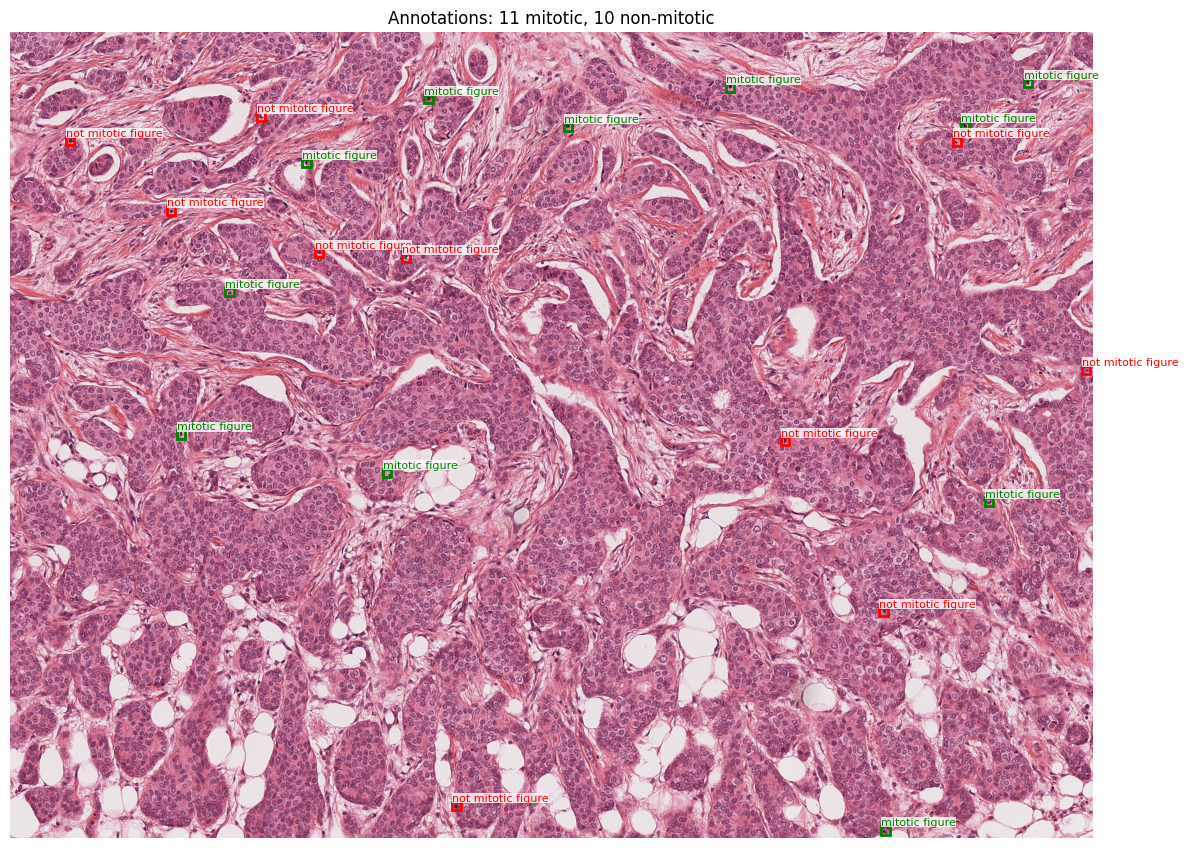


Demonstrating stain normalization effect...


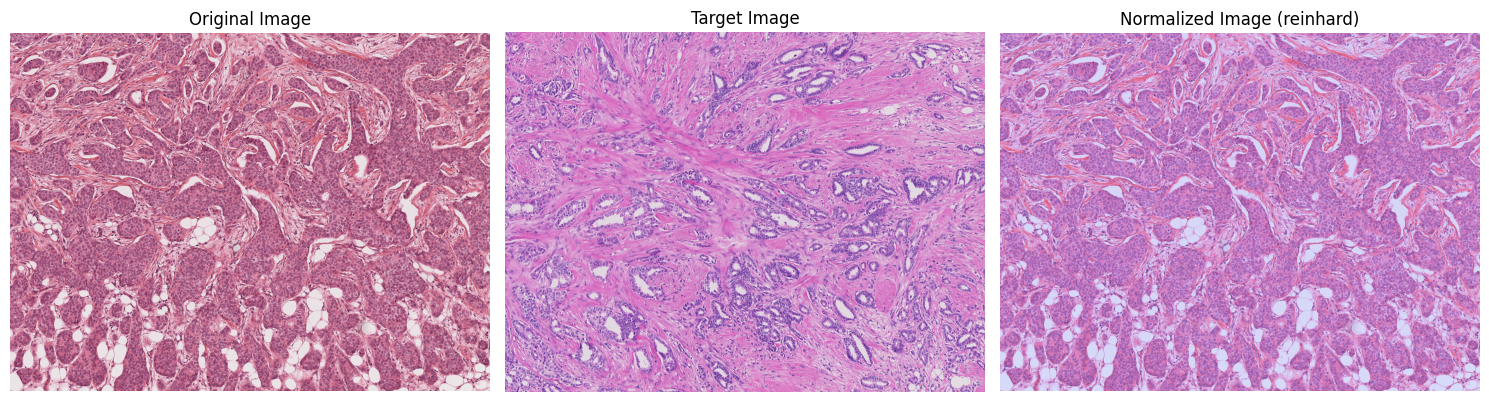


Extracting patches...

Visualizing mitotic figure patches:


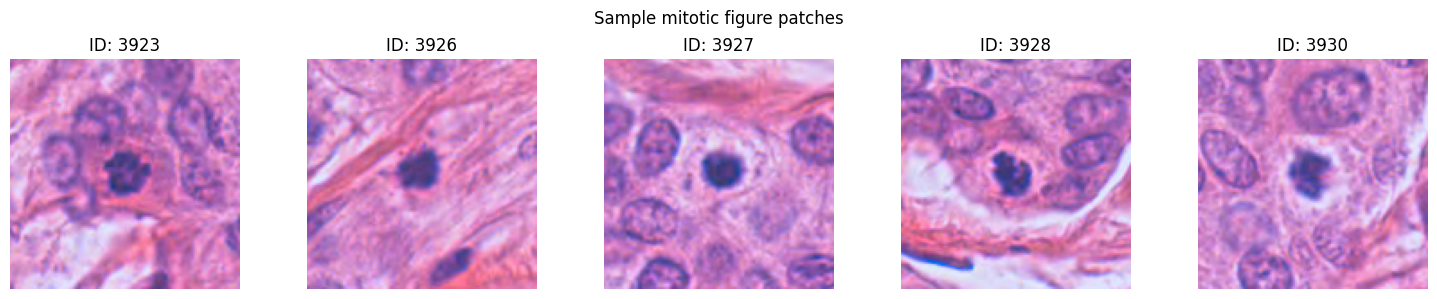


Visualizing non-mitotic figure patches:


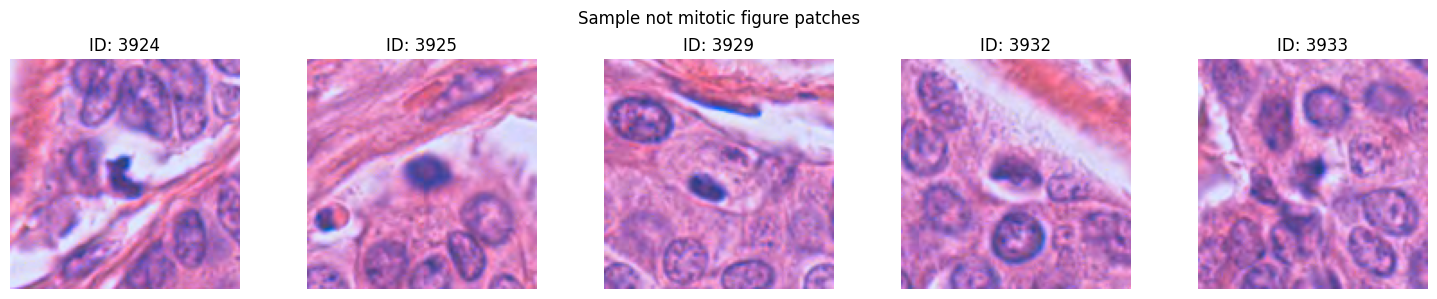

In [ ]:
base_dir = '/content/drive/My Drive/MIDOG_Challenge_2022_png'

# Available methods: 'macenko', 'reinhard', 'vahadane', 'ruifrok'
patches = demo_workflow(base_dir, use_normalization=True, method='reinhard')

All images

In [ ]:
base_dir = '/content/drive/My Drive/MIDOG_Challenge_2022_png'
annotations_json = os.path.join(base_dir, 'MIDOG2022_training_png.json')

# load the annotations
image_annotations, categories, image_info = load_and_organize_annotations(annotations_json)

# Process all images with Reinhard normalization
all_patches = process_all_images(
    base_dir,
    annotations_json,
    target_image_path=target_image_path,
    patch_size=128,
    padding=5,
    limit=None,  # Process all images
    method='reinhard'
)

# Verify we have patches
print(f"Extracted {len(all_patches['mitotic figure'])} mitotic figure patches")
print(f"Extracted {len(all_patches['not mitotic figure'])} non-mitotic figure patches")



Loading annotations...
Loaded annotations for 354 images
Extracting patches with stain normalization...


  0%|          | 0/354 [00:00<?, ?it/s]

Extracted 9501 mitotic figure patches
Extracted 11051 non-mitotic figure patches
Extracted 9501 mitotic figure patches
Extracted 11051 non-mitotic figure patches


In [ ]:
# Save patches to a pickle file
with open('midog_patches_reinhard_full.pkl', 'wb') as f:
    pickle.dump(all_patches, f)
print("Patches saved to midog_patches_reinhard_full.pkl")

# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp midog_patches_reinhard_full.pkl "/content/drive/My Drive/MIDOG_Challenge_2022_png/"
print("Full dataset saved to your Google Drive")

Patches saved to midog_patches_reinhard_full.pkl
Mounted at /content/drive
Full dataset saved to your Google Drive


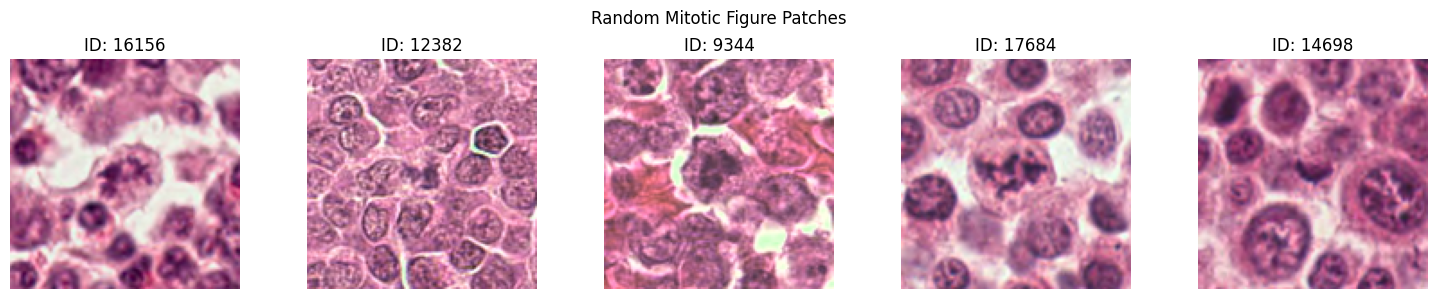

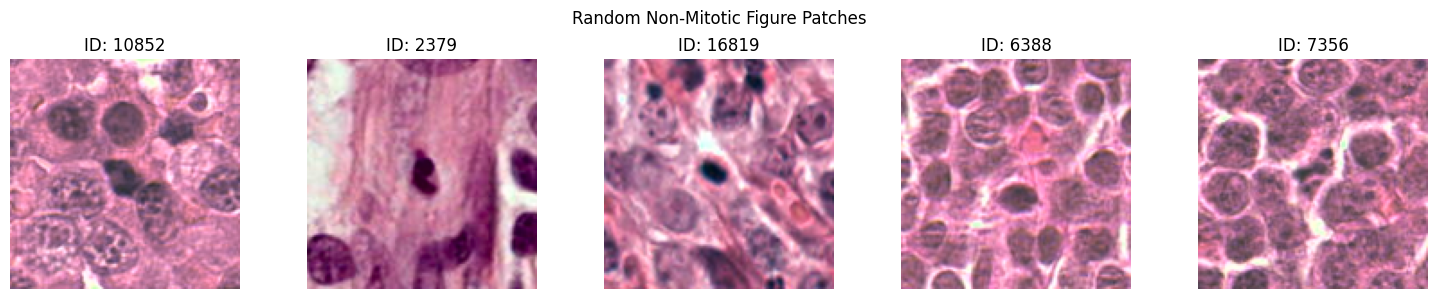

In [ ]:
import random
import matplotlib.pyplot as plt

def check_random_patches(all_patches, n_samples=5):
    """Display random patches from each category to verify quality."""
    # Check mitotic patches
    if 'mitotic figure' in all_patches and all_patches['mitotic figure']:
        plt.figure(figsize=(15, 3))
        plt.suptitle("Random Mitotic Figure Patches")

        # Get n_samples random patches
        samples = random.sample(all_patches['mitotic figure'], min(n_samples, len(all_patches['mitotic figure'])))

        for i, sample in enumerate(samples):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(sample['patch'])
            plt.title(f"ID: {sample['annotation_id']}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Check non-mitotic patches
    if 'not mitotic figure' in all_patches and all_patches['not mitotic figure']:
        plt.figure(figsize=(15, 3))
        plt.suptitle("Random Non-Mitotic Figure Patches")

        # Get n_samples random patches
        samples = random.sample(all_patches['not mitotic figure'], min(n_samples, len(all_patches['not mitotic figure'])))

        for i, sample in enumerate(samples):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(sample['patch'])
            plt.title(f"ID: {sample['annotation_id']}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()


check_random_patches(all_patches, n_samples=5)

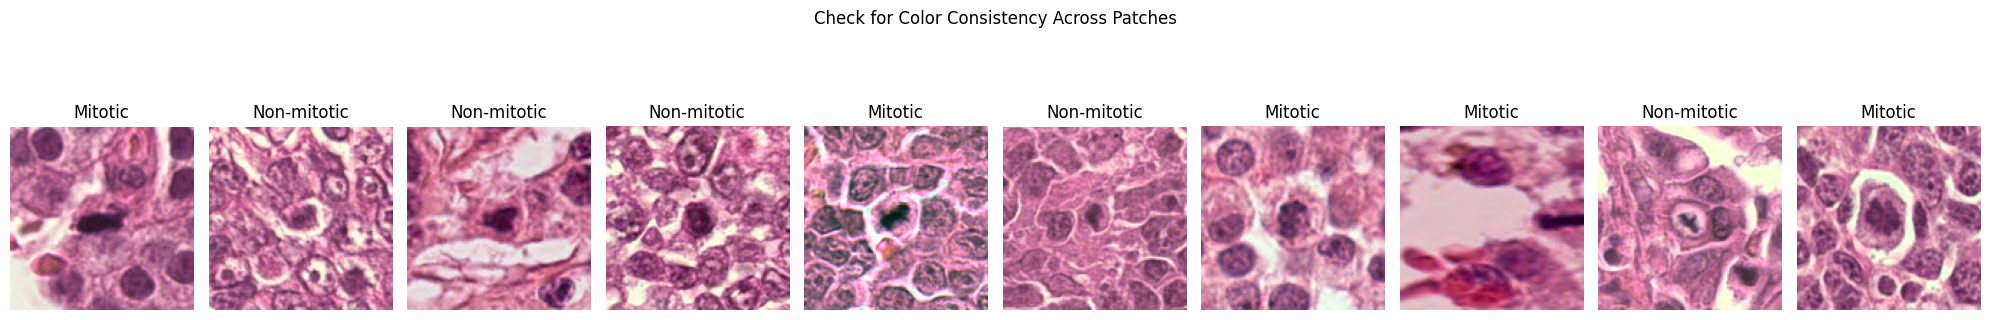

In [ ]:
def check_color_consistency(all_patches, n_samples=10):
    """Check if stain normalization produced consistent coloring across patches."""
    # Get a mix of both categories
    mitotic_samples = random.sample(all_patches['mitotic figure'],
                                   min(n_samples//2, len(all_patches['mitotic figure'])))
    non_mitotic_samples = random.sample(all_patches['not mitotic figure'],
                                       min(n_samples//2, len(all_patches['not mitotic figure'])))

    # Create a list of tuples with (patch, category)
    samples = [(patch, "Mitotic") for patch in mitotic_samples] + \
              [(patch, "Non-mitotic") for patch in non_mitotic_samples]

    random.shuffle(samples)  # Mix them up

    plt.figure(figsize=(20, 4))
    plt.suptitle("Check for Color Consistency Across Patches")

    for i, (sample, category) in enumerate(samples[:n_samples]):  # Show up to n_samples
        plt.subplot(1, n_samples, i+1)
        plt.imshow(sample['patch'])
        plt.title(f"{category}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

check_color_consistency(all_patches)